In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import pandas as pd
from scipy.io import loadmat
from scipy.stats import binned_statistic

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from poglm import utils, inference, model

from importlib import reload
reload(utils)

In [2]:
## arguments
vari_list = np.array(['F', 'FS', 'FB'])
distribution_list = np.array(['Poisson', 'categorical', 'GS-score', 'GS-pathwise', 'exponential', 'Rayleigh', 'half-normal'])
distribution_abbr_dict = {'Poisson': 'Pois', 'categorical': 'Cat', 'GS-score': 'GS-s', 'GS-pathwise': 'GS-p', 'exponential': 'Exp', 'Rayleigh': 'Ray', 'half-normal': 'HN'}
distribution_abbr_list = np.array(list(distribution_abbr_dict.values()))
n_hid_neurons_list = [1, 2, 3]
seed_list = np.arange(10)

In [3]:
df_list = []
for vari in vari_list:
    for distribution in distribution_list:
        for n_hid_neurons in n_hid_neurons_list:
            for seed in seed_list:
                try:
                    df_temp = pd.read_csv(f'csv/{vari}_{distribution}_{n_hid_neurons}_{seed}.csv')
                    df_temp['vari'] = vari
                    df_temp['distribution'] = distribution_abbr_dict[distribution]
                    df_temp['$n$ hidden neurons'] = n_hid_neurons
                    df_temp['seed'] = seed
                    df_list.append(df_temp)
                except:
                    print(vari, distribution, n_hid_neurons, seed)

    df = pd.concat(df_list, ignore_index=True)

ll_glm = pd.read_csv('csv/GLM.csv').at[0, 'marginal log-likelihood']

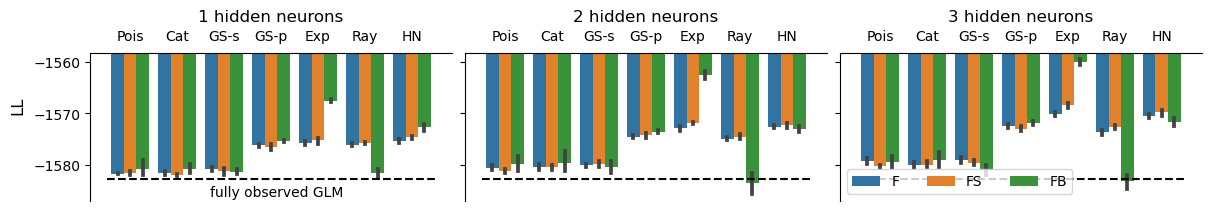

In [11]:
fig, axs = plt.subplots(1, len(n_hid_neurons_list), figsize=(12, 2), layout='constrained', sharex=True, sharey=True)
axs = axs.flat

for i, n_hid_neurons in enumerate(n_hid_neurons_list):
    ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df[df['$n$ hidden neurons'] == n_hid_neurons], ax=axs[i], order=distribution_abbr_list, hue_order=vari_list)
    ax.plot([-0.5, 6.5], [ll_glm, ll_glm], 'k--')
    ax.set(xlabel=None, ylabel=None, ylim=(-1587, df['marginal log-likelihood'].max()), title=f'{n_hid_neurons} hidden neurons')
    ax.get_legend().remove()
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_ticks_position('none')
    
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, ncols=3)
axs[0].text(1.7, -1586, 'fully observed GLM')
fig.supylabel('LL')
fig.savefig('rgc_bar.pdf', bbox_inches='tight', transparent=True)

In [7]:
def load_data():
    temp = loadmat(f'rgcData_Nature08/SpTimesRGC.mat', squeeze_me=False, struct_as_record=False)['SpTimes'][0]
    n_time_bins = 20 * 60 * 120 # 20 min * 119.9820 Hz
    time_bins = np.linspace(1, n_time_bins, n_time_bins)
    n_neurons = 27
    spikes = np.zeros((n_time_bins, n_neurons))
    for i in range(n_neurons):
        spikes[:, i] = binned_statistic(temp[i][:, 0], None, bins=np.hstack(([0], time_bins)), statistic='count')[0].T
    return spikes

spikes = load_data()

## hyper-parameters
decay = 0.25
window_size = 5
n_vis_neurons = spikes.shape[1]
basis = utils.exp_basis(decay, window_size, window_size)


vis_spikes_list_train, vis_spikes_list_test = torch.from_numpy(spikes[:96000].reshape(960, 100, -1)).to(torch.float32), torch.from_numpy(spikes[96000:].reshape(480, 100, -1)).to(torch.float32)
convolved_vis_spikes_list_train = utils.convolve_spikes_with_basis(vis_spikes_list_train, basis, 'forward')
convolved_vis_spikes_list_test = utils.convolve_spikes_with_basis(vis_spikes_list_test, basis, 'forward')

In [8]:
n_hid_neurons = 1
n_neurons = n_vis_neurons + n_hid_neurons
seed = 2

Text(0.5, 0.98, 'Learned $q$')

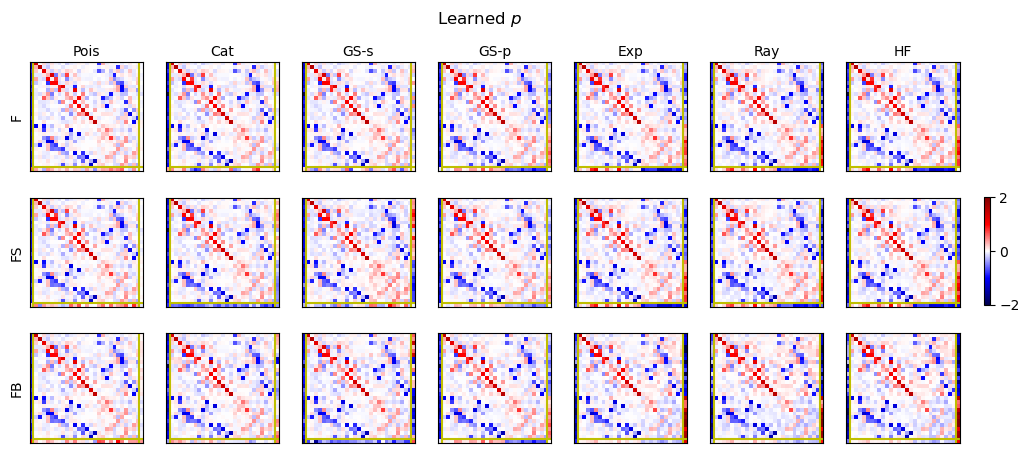

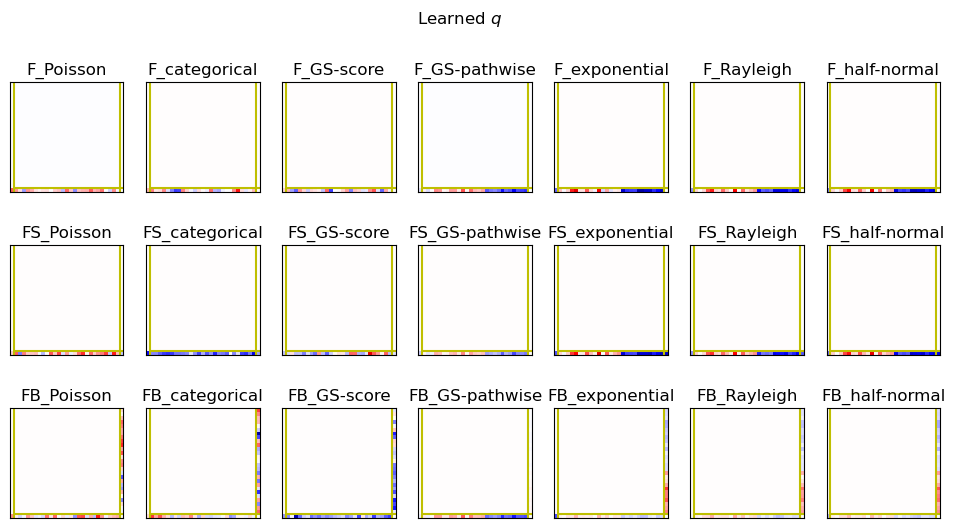

In [16]:
fig, axs = plt.subplots(3, 7, figsize=(12, 5))

for i, vari in enumerate(vari_list):
    for j, distribution in enumerate(distribution_list):
        w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_inf.pt')
        im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
for i in range(len(vari_list)):
    axs[i, 0].set_ylabel(vari_list[i])
for j in range(7):
    ax = axs[0, j]
    ax.set_xlabel(distribution_abbr_list[j])
    ax.xaxis.set_label_position('top')
fig.colorbar(im, cax=fig.add_axes([0.92, 0.39, 0.005, 0.215]), orientation='vertical')
fig.suptitle('Learned $p$')

fig, axs = plt.subplots(3, 7, figsize=(12, 6))

for i, vari in enumerate(vari_list):
    for j, distribution in enumerate(distribution_list):
        try:
            w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_vari.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
            axs[i, j].set(title=f'{vari}_{distribution}')
        except:
            pass
fig.suptitle('Learned $q$')

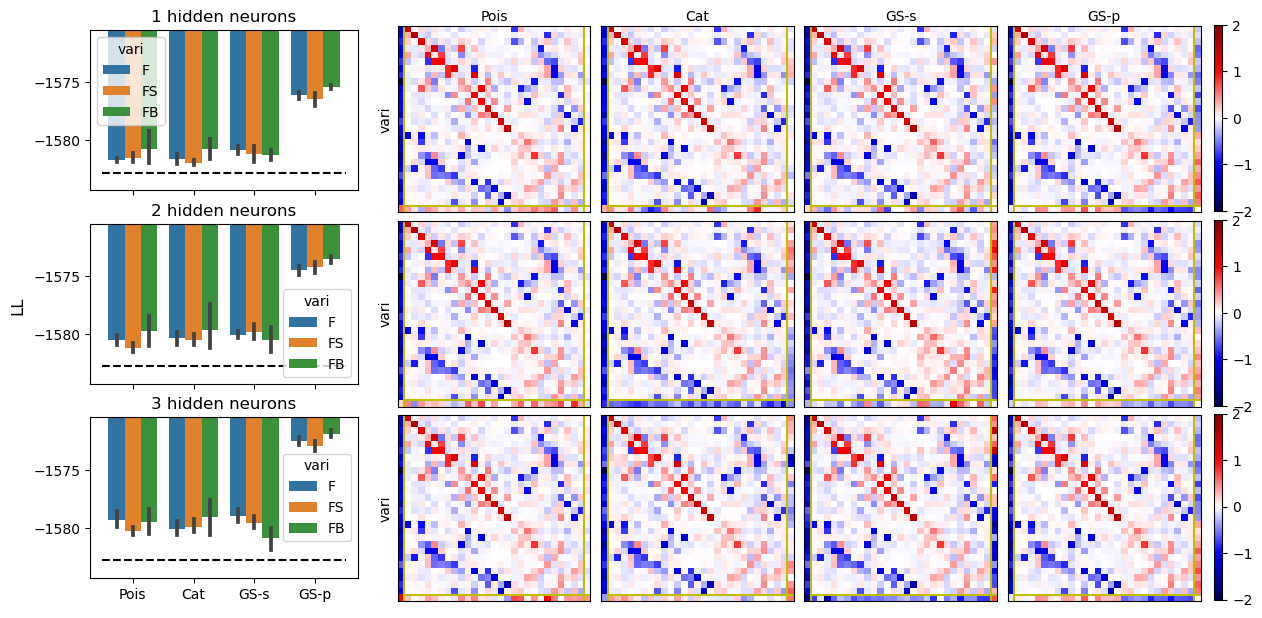

In [47]:
# fig = plt.figure(layout='constrained', figsize=(12, 6))
# subfigs = fig.subfigures(1, 2, width_ratios=[1, 2.5])

# ## barplot
# axs = subfigs[0].subplots(len(n_hid_neurons_list), 1, sharex=True)
# for i, n_hid_neurons in enumerate(n_hid_neurons_list):
#     ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df[df['$n$ hidden neurons'] == n_hid_neurons], ax=axs[i], order=distribution_abbr_dict.values(), hue_order=vari_list)
    
#     ax.plot([-0.5, 3.5], [ll_glm, ll_glm], 'k--')
#     ax.set(xlabel=None, ylabel=None, ylim=(df['marginal log-likelihood'].min(), df['marginal log-likelihood'].max()), title=f'{n_hid_neurons} hidden neurons')
# fig.supylabel('LL')


# n_hid_neurons = 1
# n_neurons = n_vis_neurons + n_hid_neurons
# seed = 2

# ## weight
# axs = subfigs[1].subplots(3, 4)
# for i, vari in enumerate(vari_list):
#     for j, distribution in enumerate(distribution_list):
#         w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_inf.pt')
#         im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)

# for i in range(4):
#     ax = axs[0, i]
#     ax.xaxis.set_label_position('top')
#     ax.set(xlabel=distribution_abbr_dict[distribution_list[i]])
# for i in range(3):
#     axs[i, 0].set_ylabel('vari')

# subfigs[1].colorbar(im, cax=subfigs[1].add_axes([1.01, 0.01, 0.01, 0.31]), orientation='vertical')
# subfigs[1].colorbar(im, cax=subfigs[1].add_axes([1.01, 0.333, 0.01, 0.31]), orientation='vertical')
# subfigs[1].colorbar(im, cax=subfigs[1].add_axes([1.01, 0.658, 0.01, 0.31]), orientation='vertical')
        
# fig.savefig('rgc.pdf', bbox_inches='tight', transparent=True)

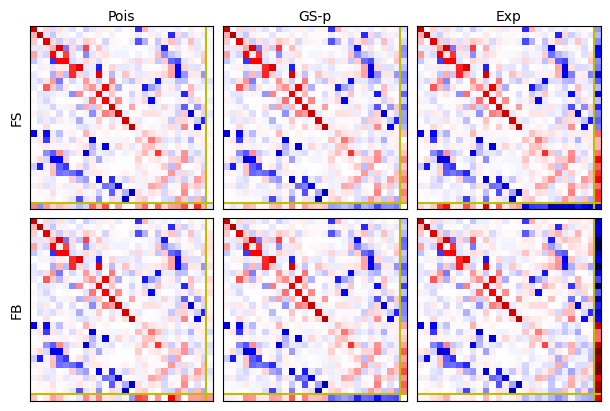

In [46]:
seed = 2
n_hid_neurons = 1
n_neurons = n_vis_neurons + n_hid_neurons

fig, axs = plt.subplots(2, 3, figsize=(6, 4), layout='constrained')

for i, vari in enumerate(vari_list[[1, 2]]):
    for j, distribution in enumerate(distribution_list[[0, 3, 4]]):
        w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_inf.pt')
        im = utils.visualize_weight(w['linear.weight'], n_neurons, n_vis_neurons, axs[i, j], v=2)
for i in range(len(vari_list[[1, 2]])):
    axs[i, 0].set_ylabel(vari_list[[1, 2]][i])
for j in range(3):
    ax = axs[0, j]
    ax.set_xlabel(distribution_abbr_list[[0, 3, 4]][j])
    ax.xaxis.set_label_position('top')
    subfigs[n_hid_neurons-1].colorbar(im, cax=subfigs[n_hid_neurons-1].add_axes([1, 0.32, 0.005, 0.29]), orientation='vertical')
fig.savefig('rgc_selected_weight.pdf', bbox_inches='tight', transparent=True)

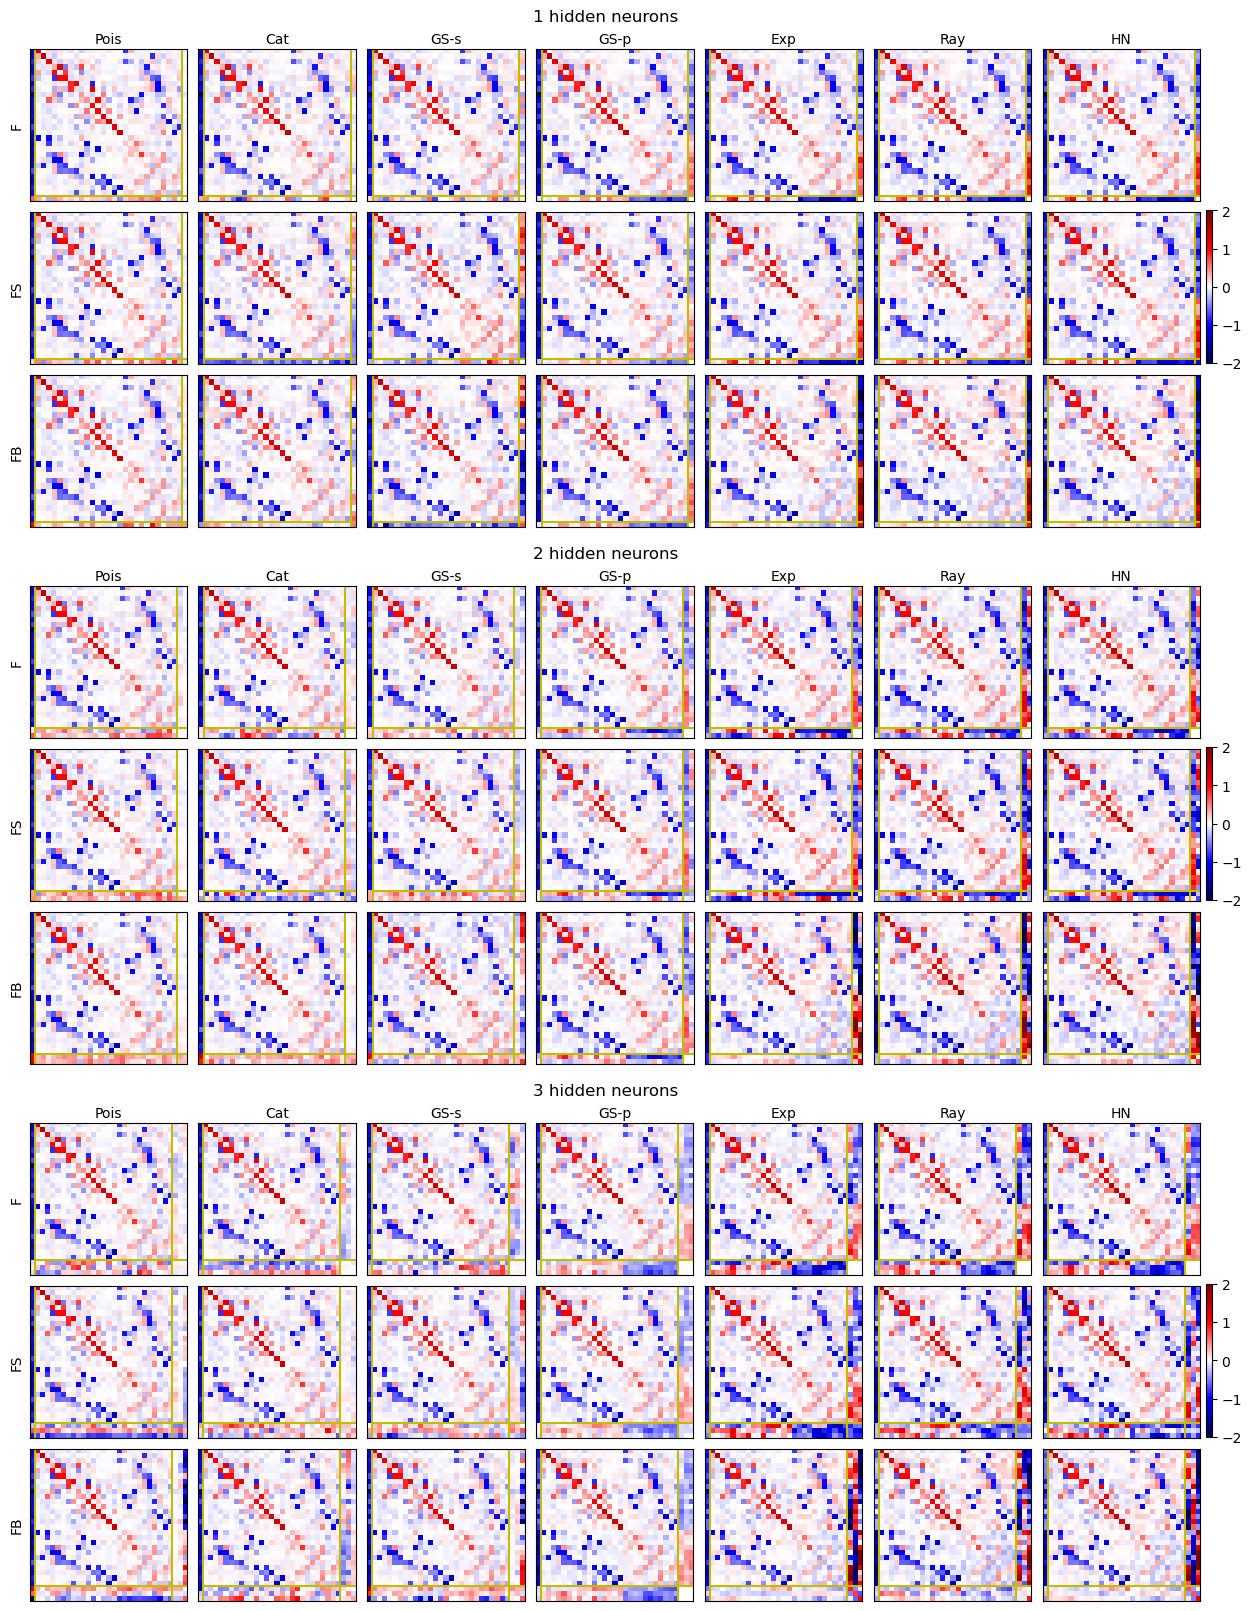

In [49]:
seed = 2

fig = plt.figure(figsize=(12, 16), layout='constrained')
subfigs = fig.subfigures(3, 1)

for n_hid_neurons in range(1, 4):
    n_neurons = n_vis_neurons + n_hid_neurons
    axs = subfigs[n_hid_neurons-1].subplots(3, 7)

    for i, vari in enumerate(vari_list):
        for j, distribution in enumerate(distribution_list):
            w = torch.load(f'model/{vari}_{distribution}_{n_hid_neurons}_{seed}_inf.pt')
            im = utils.visualize_linear(w, n_neurons, n_vis_neurons, axs[i, j], v=2)
    for i in range(len(vari_list)):
        axs[i, 0].set_ylabel(vari_list[i])
    for j in range(7):
        ax = axs[0, j]
        ax.set_xlabel(distribution_abbr_list[j])
        ax.xaxis.set_label_position('top')
    subfigs[n_hid_neurons-1].colorbar(im, cax=subfigs[n_hid_neurons-1].add_axes([1, 0.32, 0.005, 0.29]), orientation='vertical')
    subfigs[n_hid_neurons-1].suptitle(f'{n_hid_neurons} hidden neurons')
fig.savefig('rgc_weight.pdf', bbox_inches='tight', transparent=True)

In [18]:
df_2 = df.copy()
df_2['marginal log-likelihood'] = df_2['marginal log-likelihood'] / (27 * 100)
ll_glm = ll_glm / (27 * 100)

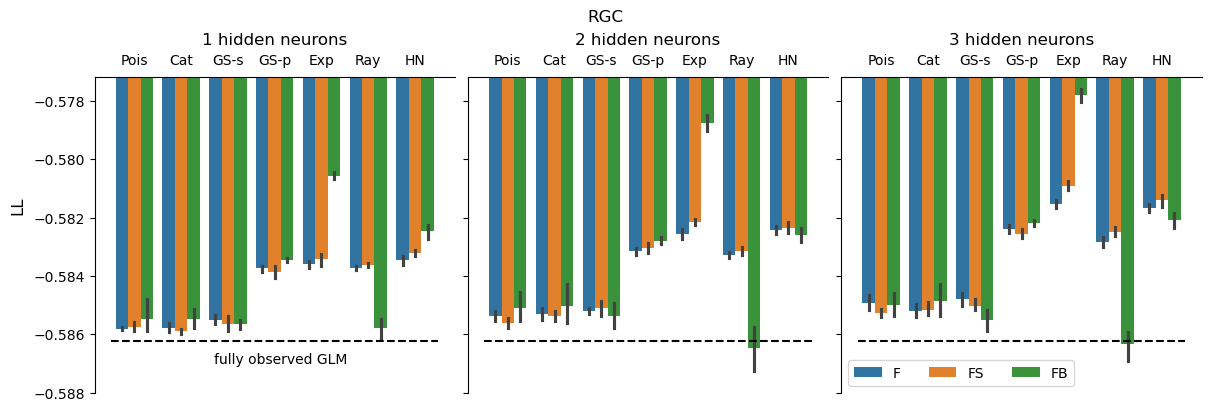

In [25]:
fig, axs = plt.subplots(1, len(n_hid_neurons_list), figsize=(12, 4), layout='constrained', sharex=True, sharey=True)
axs = axs.flat

for i, n_hid_neurons in enumerate(n_hid_neurons_list):
    ax = sns.barplot(x='distribution', y='marginal log-likelihood', hue='vari', data=df_2[df_2['$n$ hidden neurons'] == n_hid_neurons], ax=axs[i], order=distribution_abbr_list, hue_order=vari_list)
    ax.plot([-0.5, 6.5], [ll_glm, ll_glm], 'k--')
    ax.set(xlabel=None, ylabel=None, ylim=(-0.588, df_2['marginal log-likelihood'].max()), title=f'{n_hid_neurons} hidden neurons')
    ax.get_legend().remove()
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_ticks_position('none')
    
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, ncols=3)
axs[0].text(1.7, -0.587, 'fully observed GLM')
fig.supylabel('LL')
fig.suptitle('RGC')
fig.savefig('rgc_CI.pdf', bbox_inches='tight', transparent=True)